In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 500)

# Load and Clean Data

In [2]:
companies = pd.read_excel('masked_3_NAICS_codes_20190520 (with LineOfBusiness and Officer).xlsx')

In [3]:
# show missing values in each column
print ('Companies: %.0f, Fields: %.0f' % (companies.shape))
companies.isnull().sum()

Companies: 1092, Fields: 325


masked EntityID                       0
CPR $net_inc_YTD                    666
CPR_Group                           666
CPR_rm                              666
IndustryCode                          0
IndustryClass                         0
IndustryType                        245
entityID_x                            0
customerID_C                          0
customerID_m                          0
rank_by_dt                            0
rank_by_stmt_id                       0
CustomerID                            0
ContextID                             0
StatementID                           0
CustomerName                          0
StatementDate                         0
StatementMonths                       0
AuditMethod                           1
Accountant                          344
Analyst                              49
StatementType                         0
Cash                                  1
MarketableSec                         4
AcctsRecTrade                         0


In [4]:
# show missing values by row
len(companies[pd.isnull(companies).any(axis=1)])

1092

In [5]:
# is there any rows for which we have essentially no data at all?
max(companies.isnull().sum(axis=1))

161

## Data Cleanup

All rows have one missing value. Let's run through the columns to do some data cleanup.

### Part I: Feature Cleaning

#### 1. Drop Columns by missing value percentage

In [6]:
# check columns with more than 90% missing value  [- 34 columns]
print(companies.columns[(companies.isna().sum()/len(companies))>0.9])
# drop columns with more than 90% missing value
companies.drop(columns=companies.columns[(companies.isna().sum()/len(companies))>0.9], inplace=True)

Index(['CovWorkingCapital', 'CovCapitalExpend', 'CovOwnerSalary',
       'CovLeaseExpend', 'CovDividends', 'CovSubDebtPaymts', 'CovNewDebt',
       'CovMinimumTNW', 'CovMinCashBal', 'CovCurrentRatio', 'CovQuickRatio',
       'CovDebtToTNW', 'CovInterestCover', 'CovFundsFlwCover',
       'CovProfitMargin', 'CovRetOnEquity', 'CovRetOnAssets',
       'CovAcctsRecDays', 'CovInventoryDays', 'CovAcctsPayDays',
       'CovMaxSalesGrow', 'COGSToInventory', 'COGSToAcctsPay', 'CashAndEquivs',
       'LEASE_ADJUSTED_LEVERAGE', 'LT_REC_AND_INVEST_NFP',
       'OTHER_NON_CUR_ASSETS_NFP', 'NET_OP_EXP_NFP', 'DEPR_AND_AMORT_NFP',
       'UNRESTRICTED_LIQ_TO_DEBT_NFP', 'TOTAL_LIQ_TO_TFD',
       'DAYS_CASH_ON_HAND_NFP', 'AGE_OF_PLANT_YRS',
       'SENIOR_LEASE_ADJUSTED_LEVERAGE'],
      dtype='object')


#### 2. Drop columns with only 1 value

In [7]:
# check and drop columns with only 1 value [- 9 columns]
for col in companies.columns.values:
    if len(companies[col].unique()) == 1:
        print(col)
        companies.drop(columns=col, inplace=True)

IndustryClass
rank_by_dt
rank_by_stmt_id
ContextID
AcctsRecRelCo
CREATE_BY_NM
CREATE_BY_DT
LAST_UPDATE_BY_NM
LAST_UPDATE_BY_DT


#### 3. Drop ratios

In [8]:
# drop ratios [- 29 columns]
ratio_columns = list(companies.filter(regex='RT$', axis=1).columns)
companies.drop(columns=ratio_columns, inplace=True)

#### 4. Drop irrelevant columns

In [9]:
# drop irrelevant columns [- 10 columns]
irr_columns = ['CPR_rm',
              'IndustryType',
              'entityID_x', #exactly the same as 'masked EntityID'
              'customerID_C',
               'customerID_m',
               'CustomerID',
              'StatementID',
               'CustomerName',
              'Accountant',
               'Analyst']
companies.drop(columns=irr_columns, inplace=True)

#### 5. Deal with 'StatementDate'

In [10]:
# create 'Year' column [+ 1 column]
companies['Year'] = companies.StatementDate.str[1:5].astype(int)
# drop 'StatementDate' and 'StatementYear' columns [- 2 columns]
companies.drop(columns=['StatementDate', 'StatementYear'], inplace=True)

#### 6. Filter by / Deal with 'StatementMonth'

In [11]:
# check records where 'StatementMonth' is not 12 months
# loss 3 records
# filter out records where 'StatementMonth' is not 12 months
companies = companies[companies.StatementMonths==12]
# drop columns [- 1 column]
companies.drop(columns=['StatementMonths'], inplace=True)

#### 7. 'FixedAssets' vs. 'GrossFixedAssets'

In [12]:
# two columns are almost the same with four exceptions
companies[companies.FixedAssets!=companies.GrossFixedAssets][['FixedAssets', 'GrossFixedAssets']]
# drop 'GrossFixedAssets' because the only different value is NA [- 1 column]
companies.drop(columns=['GrossFixedAssets'], inplace=True)

#### 8. Final Selection

In [13]:
obj_columns = companies.iloc[:,:(companies.columns.get_loc('StatementType')+1)].columns.to_list()
BS_columns = companies.iloc[:,companies.columns.get_loc('Cash'):(companies.columns.get_loc('TotLiabsNetWorth')+1)].columns.to_list()
IS_columns = companies.iloc[:,companies.columns.get_loc('GrossSales'):(companies.columns.get_loc('AdjToRE')+1)].columns.to_list()
Growth_columns = list(companies.filter(regex='Growth$', axis=1).columns)
Growth_columns.extend(list(companies.filter(regex='Grow$', axis=1).columns))

col = obj_columns + BS_columns + IS_columns + list(['ConversionRate', 'QuickRatio', 'CurrentRatio', 'Year']) + Growth_columns
companies = companies[col]

In [14]:
# can't replace 999/-999 for now, avoid mis-replacement
# there are many 999/-999 in BS/IS
companies[((companies.iloc[:, :121]==999) | (companies.iloc[:, :121]==-999)).any(axis=1)]

,masked EntityID,CPR $net_inc_YTD,CPR_Group,IndustryCode,AuditMethod,StatementType,Cash,MarketableSec,AcctsRecTrade,BadDebtReserve,NetTradeAcctsRec,AcctsRecOther,RawMaterialsInv,WIPInv,FinGoodsInv,OtherInv,TotalInventory,IncTaxReceivable,CostsInExcBill,OtherOperAssets,NonOpCurAssets,LifoReserve,OffBSCurAsts,TotalCurAssets,DefIncTaxRec,ConstInProgress,Land,FixedAssets,AccumDeprec,NetFixedAssets,LongTermAcctsRec,LongTermInvest,OpNonCurAssets,LongTermPrepaids,NonOpNonCurAsts,Intangibles,AccumAmort,NetIntangibles,OffBSNonCurAsts,TotalNonCurAsts,TotalAssets,Overdrafts,STLoansPayable,CPLTD,CPSubDebt,AcctsPayTrade,AcctsPayOther,AccruedLiabs,InterestPayable,DividendsPayable,TotalAccrdLiabs,IncTaxesPayable,OtherOperLiabs,BillInexcCosts,NonOpCurLiabs,OffBSCurLiabs,TotalCurLiabs,LongTermDebt,CapLeaseOblig,DefIncTaxPayable,NonOpNonCurLiabs,OpNonCurLiabs,DueToRelParty,OffBSNonCurLiabs,SubDebtLiabs,MinorityIntLiabs,TotalNonCurLiabs,TotalLiabs,SubDebtEquity,MinIntEquity,PreferredStock,CommonStock,OtherEquity,TreasuryStock,CurrencyTranslat,RetainedEarnings,AccumulatedOCI,TotalNetWorth,TotLiabsNetWorth,GrossSales,SalesReturns,NetSales,CostOfGoodsSold,COGSDepreciation,TotalCOGS,GrossProfit,OperExpenses,SellingAndGenExp,OfficersComp,LeaseRentExp,DeprecExpense,AmortExpense,ESOPDividends,TotalOpExpenses,OtherOperIncome,NetOpProfit,InterestIncome,InterestExpense,NonCashIncome,NonCashExpense,OtherIncome,IncomeFromSubs,GainLossAstSale,OtherExpense,TotalOtherIncExp,ProfitBeforeTax,IncomeTaxExp,IncomeTaxCredit,NetIncomeTaxExp,MinorityIntExp,ProfitB4ExtItems,AfterTaxIncome,AftTaxNonCashExp,AfterTaxExpense,NetProfit,OtherCompIncome,CompIncome,DividendsStock,DividendsCommon,DividendsPref,AdjToRE,ConversionRate,QuickRatio,CurrentRatio,Year,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,AdjustedEBITDAGrowth,GrossProfitGrowth,SustainableGrow
74,304,0.000000,COMMERCIAL BANKING,311511,Co.Prep'd,Annual,0.0,0.0,20742.0,0.0,20742.0,0,0.0,0.0,11560.0,0.0,11560.0,0.0,0.0,0.0,0.0,0.0,0.0,32302.0,0.0,0.0,0.0,73871.0,0.0,73871.0,0,2956.0,1426.0,999.0,0.0,112252.0,0.0,112252.0,0.0,191504.0,223806.0,0.0,0.0,0.0,0,32026.0,0.0,6964.0,0.0,0.0,6964.0,5497.0,0.0,0.0,0.0,0.0,44487.0,0.0,0.0,0.0,0,19471.0,0,0.0,0.0,0.0,19471.0,63958.0,0,0.0,0,61.0,13946.0,0.0,0.0,145841.0,0.0,159848.0,223806.0,350218.0,0.0,350218.0,254057.0,12280.0,266337.0,83881.0,0.0,53795.0,0.0,0.0,0.0,0.0,0.0,53795.0,0,30086.0,24.0,13.0,0.0,0.0,-17.0,0.0,0.0,0.0,-6.0,30080.0,13247.0,0.0,13247.0,0.0,16833.0,0.0,0,0,16833.0,0.0,16833.0,0,21012.0,0,0.0,1.0,0.466249,0.726100,2015,0.586062,-20.950698,12.892586,4.052552,0.081763,9.789982,1.575200,9.416660,-4.192886
95,40407,NaN,NaN,236220,Reviewed,Annual,437.0,0.0,656.0,0.0,656.0,0,0.0,0.0,0.0,0.0,0.0,0.0,162.0,0.0,0.0,0.0,0.0,1255.0,1.0,0.0,55.0,888.0,675.0,213.0,0,622.0,0.0,23.0,0.0,582.0,0.0,582.0,0.0,1441.0,2696.0,0.0,0.0,0.0,0,511.0,0.0,16.0,0.0,0.0,16.0,107.0,992.0,0.0,0.0,0.0,1626.0,0.0,0.0,0.0,0,987.0,0,0.0,0.0,0.0,987.0,2613.0,0,0.0,0,23.0,0.0,1106.0,0.0,999.0,167.0,83.0,2696.0,4820.0,0.0,4820.0,3989.0,9.0,3998.0,822.0,421.0,0.0,277.0,0.0,20.0,0.0,0.0,718.0,0,104.0,14.0,58.0,0.0,0.0,8.0,0.0,-5.0,0.0,-41.0,63.0,13.0,0.0,13.0,0.0,50.0,0.0,0,0,50.0,55.0,105.0,0,0.0,0,0.0,1.0,0.672202,0.771833,2013,8.665861,86.909871,-92.336103,-12.933526,-0.737374,-80.468750,-68.557920,-33.709677,-7.284611
136,2731,431.588148,BUSINESS BANKING,332312,Unqualif'd,Annual,3026.0,0.0,999.0,0.0,999.0,0,0.0,0.0,3348.0,0.0,3348.0,0.0,0.0,0.0,0.0,2977.0,0.0,7373.0,0.0,0.0,0.0,1106.0,910.0,196.0,0,0.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,209.0,7582.0,0.0,0.0,0.0,0,93.0,0.0,190.0,0.0,0.0,190.0,0.0,292.0,0.0,0.0,0.0,575.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,575.0,0,0.0,0,10.0,0.0,65.0,0.0,7062.0,0.0,7007.0,7582.0,20157.0,0.0,20157.0,12516.0,0.0,12516.0,7641.0,4426.0,0.0,660.0,272.0,57.0,0.0,0.0,5415.0,0,2226.0,3.0,0.0,0.0,0.0,51.0,0.0,0.0,1.0,53.0,2279.0,0.0,0.0,0.0,0.0,2279.0,0.0,0,0,2279.0,0.0,2279.0,0,2500.0,0,0.0,1.0,7.000000,12.822609,2015,-

In [15]:
# Add back Industry Type
industry_code_type = {'11': 'Agriculture, Forestry, Fishing and Hunting',
                     '21': 'Mining, Quarrying, and Oil and Gas Extraction',
                     '22': 'Utilities',
                     '23': 'Construction',
                     '31': 'Manufacturing',
                     '32': 'Manufacturing',
                     '33': 'Manufacturing'}
def add_industry_type(row):
    return industry_code_type[str(str(row['IndustryCode'])[:2])]
companies['IndustryType'] = companies.apply(add_industry_type, axis=1)

### Part II: Record cleaning

#### 1. Internal Consistency Check

In [16]:
def validate_balance_sheet_level_1(row):
    return not abs(row['TotalAssets'] - (row['TotalLiabs'] + row['TotalNetWorth'])) < 1

def validate_balance_sheet_level_2(row):
    assets = abs(row['TotalAssets'] - (row['TotalCurAssets'] + row['TotalNonCurAsts'])) < 1
    liabs = abs(row['TotalLiabs'] - (row['TotalCurLiabs'] + row['TotalNonCurLiabs'])) < 1
    equity = abs(row['TotalNetWorth'] - (row['SubDebtEquity'] + row['MinIntEquity'] +
              row['PreferredStock'] + row['CommonStock'] + row['OtherEquity'] -
              row['TreasuryStock'] + row['CurrencyTranslat'] + row['RetainedEarnings'] +
              row['AccumulatedOCI'])) < 1
    return not (assets and liabs and equity)

def validate_income_statement(row):
    net_sales = abs(row['NetSales'] - (row['GrossSales'] - row['SalesReturns'])) < 1
    total_cogs = abs(row['TotalCOGS']- (row['CostOfGoodsSold'] + row['COGSDepreciation'])) < 1
    gross_profit = abs(row['GrossProfit'] - (row['NetSales'] - row['TotalCOGS'])) < 1
    total_opex = abs(row['TotalOpExpenses'] - (row['OperExpenses'] + row['SellingAndGenExp'] +
                  row['OfficersComp'] + row['LeaseRentExp'] + row['DeprecExpense'] + 
                  row['AmortExpense'] + row['ESOPDividends'])) < 1
    op_profit = abs(row['NetOpProfit'] - (row['GrossProfit'] - row['TotalOpExpenses'] - row['OtherOperIncome'])) < 1
    total_other = abs(row['TotalOtherIncExp'] - (row['InterestIncome'] - row['InterestExpense'] +
                   row['NonCashIncome'] - row['NonCashExpense'] + row['OtherIncome'] +
                   row['IncomeFromSubs'] + row['GainLossAstSale'] - row['OtherExpense'])) < 1
    pre_tax = abs(row['ProfitBeforeTax'] - (row['NetOpProfit'] + row['TotalOtherIncExp'])) < 1
    net_tax = abs(row['NetIncomeTaxExp'] - (row['IncomeTaxExp'] + row['IncomeTaxCredit'])) < 1
    net_income = abs(row['NetProfit'] - (row['ProfitBeforeTax'] - row['NetIncomeTaxExp'] - row['MinorityIntExp']
                                      + row['AfterTaxIncome'] - row['AftTaxNonCashExp'] - row['AfterTaxExpense'])) < 1
    return not (net_sales and total_cogs and gross_profit and total_opex and 
                op_profit and total_other and pre_tax and net_tax and net_income)

def validate_ratios(row):
    if row['TotalCurLiabs'] != 0:
        quick_ratio = abs(row['QuickRatio'] -
                      ((row['Cash'] + row['MarketableSec'] + row['NetTradeAcctsRec'] +
                          row['AcctsRecOther'])/row['TotalCurLiabs'])) < 0.0001
        current_ratio = abs(row['CurrentRatio'] - row['TotalCurAssets']/row['TotalCurLiabs']) < 0.0001
        return not (quick_ratio and current_ratio)

def validate_data(companies):
    # balance sheet level 1 validation
    companies['BS_1'] = companies.apply(validate_balance_sheet_level_1, axis=1) 
    # balance sheet level 2 validation
    companies['BS_2'] = companies.apply(validate_balance_sheet_level_2, axis=1)    
    # income statement level 1 validation
    companies['IS_1'] = companies.apply(validate_income_statement, axis=1)   
    # ratio calculations
    companies['Ratio_Check'] = companies.apply(validate_ratios, axis=1)   
    # filter out statement types that might be unreliable
    BAD_PREP_TYPES = ['Other *', 'Draft', 'Pro Forma', 'Projection', 'Unknown']
    companies['Bad_Prep'] = companies['AuditMethod'].fillna('Unknown').isin(BAD_PREP_TYPES)
    return companies

In [17]:
# Check completeness of BS/IS
companies['BS_null'] = companies[BS_columns].isnull().any(axis=1)
companies['IS_null'] = companies[IS_columns].isnull().any(axis=1)

In [18]:
# run validation
companies = validate_data(companies)
companies['validation_fails'] = companies[['BS_null', 'IS_null', 'BS_1', 'BS_2', 'IS_1', 'Ratio_Check', 'Bad_Prep']].any(axis=1)
print ('Validation Summary')
print ('------------------')
print ('Entries failing validation %.2f' % np.mean(companies['validation_fails']))
print ('------------------')
print ('Null Balance Sheet Items: %.2f' % np.mean(companies['BS_null']))
print ('Null Income Statement Items: %.2f' % np.mean(companies['IS_null']))
print ('High Level Balance Sheet Issues: %.2f' % (np.mean(companies['BS_1'])))
print ('Low Level Balance Sheet Issues: %.2f' % (np.mean(companies['BS_2'])))
print ('Income Statement Issues: %.2f' % (np.mean(companies['IS_1'])))
print ('Ratio Calc Issues: %.2f' % np.mean(companies['Ratio_Check']))
print ('Undesirable Prep Type: %.2f' % (np.mean(companies['Bad_Prep'])))

Validation Summary
------------------
Entries failing validation 0.15
------------------
Null Balance Sheet Items: 0.00
Null Income Statement Items: 0.00
High Level Balance Sheet Issues: 0.00
Low Level Balance Sheet Issues: 0.00
Income Statement Issues: 0.05
Ratio Calc Issues: 0.00
Undesirable Prep Type: 0.12


In [19]:
# drop rows that don't pass the validation
companies = companies[~companies['validation_fails']]
print (companies.shape)

(921, 143)


#### 2. Year

In [20]:
companies.Year.value_counts().to_frame().reset_index().\
            rename(columns={'index':'Year', 'Year':'Count'}).sort_values(by=['Year'], ascending=False).head(4)

,Year,Count
14,2019,18
0,2018,129
5,2017,65
9,2016,36


In [21]:
len(companies[companies.Year>=2016])

248

***

#### Check NA / Zero Value Again

([], <a list of 0 Text xticklabel objects>)

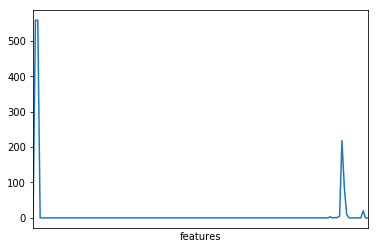

In [22]:
# Check NA value Again
companies.isna().sum().plot()
plt.xlabel('features')
plt.xticks([])

In [23]:
# Columns with NA value
companies.isna().sum()[companies.isna().sum()!=0]

CPR $net_inc_YTD        558
CPR_Group               558
TotalLiabsGrowth          3
NetSalesGrowth            1
OpProfitGrowth            1
NetProfitGrowth           5
AdjustedEBITDAGrowth    218
GrossProfitGrowth        87
SustainableGrow          10
Ratio_Check              20
dtype: int64

In [24]:
# Check value=0
manyzero_columns = []
for col in companies.columns:
    if (companies[col]==0).sum()/len(companies[col]) > 0.9:
        manyzero_columns.append(col)
        # print(col)
        # print((companies[col]==0).sum()/len(companies[col]))
        # print('---------')

In [25]:
print('%.0f columns has more than 90 percent zero value.' % (len(manyzero_columns)))
print(manyzero_columns)

46 columns has more than 90 percent zero value.
['MarketableSec', 'AcctsRecOther', 'OtherInv', 'OtherOperAssets', 'NonOpCurAssets', 'LifoReserve', 'OffBSCurAsts', 'LongTermAcctsRec', 'OffBSNonCurAsts', 'Overdrafts', 'CPSubDebt', 'AcctsPayOther', 'InterestPayable', 'DividendsPayable', 'NonOpCurLiabs', 'OffBSCurLiabs', 'CapLeaseOblig', 'NonOpNonCurLiabs', 'DueToRelParty', 'OffBSNonCurLiabs', 'MinorityIntLiabs', 'SubDebtEquity', 'MinIntEquity', 'PreferredStock', 'CurrencyTranslat', 'SalesReturns', 'ESOPDividends', 'OtherOperIncome', 'NonCashIncome', 'NonCashExpense', 'IncomeFromSubs', 'IncomeTaxCredit', 'MinorityIntExp', 'AfterTaxIncome', 'AftTaxNonCashExp', 'AfterTaxExpense', 'DividendsStock', 'DividendsPref', 'BS_null', 'IS_null', 'BS_1', 'BS_2', 'IS_1', 'Ratio_Check', 'Bad_Prep', 'validation_fails']


***
### Part III: Data Normality Check

#### 1. Qualitative features

In [26]:
# check the object features
for col in ['CPR_Group', 'IndustryType', 'AuditMethod', 'StatementType']:
    print(col)
    print(companies[col].value_counts())
    print('-'*34)

CPR_Group
BUSINESS BANKING                     209
COMMERCIAL BANKING                   124
CITIZENS RESTRUCTURING MANAGEMENT     24
GLOBAL RESTRUCTURING GROUP             5
RISK MANAGEMENT                        1
Name: CPR_Group, dtype: int64
----------------------------------
IndustryType
Manufacturing    694
Construction     227
Name: IndustryType, dtype: int64
----------------------------------
AuditMethod
Tax Return    248
Co.Prep'd     224
Unqualif'd    174
Reviewed      164
Compiled       96
Qualified      13
10Q             1
TAX RET         1
Name: AuditMethod, dtype: int64
----------------------------------
StatementType
Annual          813
TTM              78
Rolling Stmt     30
Name: StatementType, dtype: int64
----------------------------------


#### 2. Balance Sheet and Income Statement Check

#### 2.1 Completeness Check

In [27]:
# check the proportion of valid value in BS/IS columns
def validata_balance_sheet_completeness(row):
    return (row[BS_columns]!=0).sum()/len(BS_columns)
def validata_income_statement_completeness(row):
    return (row[IS_columns]!=0).sum()/len(IS_columns)
companies['BS_completeness'] = companies.apply(validata_balance_sheet_completeness, axis=1)
companies['IS_completeness'] = companies.apply(validata_income_statement_completeness, axis=1)

In [28]:
# drop the rows with <8 records for BS, or <10 records for IS [- 6 records]
companies = companies[~((companies['BS_completeness'] < 8/len(BS_columns)) |
                       (companies['IS_completeness'] < 10/len(IS_columns)))]

#### 2.2 Balance Sheet Normality Check

count    9.150000e+02
mean     6.042205e+05
std      4.506349e+06
min      8.000000e+00
25%      1.019500e+03
50%      4.694000e+03
75%      3.313350e+04
max      9.906673e+07
Name: TotalAssets, dtype: float64


Text(0.5, 0, 'log(TotalAssets)')

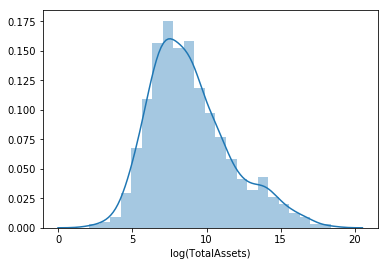

In [29]:
print(companies.TotalAssets.describe())
sns.distplot(np.log(companies.TotalAssets))
plt.xlabel('log(TotalAssets)')

In [30]:
# Cut `TotalAssets` into categories by size
def total_asset_size(row):
    if row['TotalAssets'] <= 25000:
        return '< 25000'
    elif (row['TotalAssets'] > 25000) & (row['TotalAssets'] <= 250000):
        return '25000 to 250000'
    elif (row['TotalAssets'] > 250000) & (row['TotalAssets'] < 5000000):
        return '250000 to 5000000'
    else: return '> 5000000'
companies['TotalAssetsSize'] = companies.apply(total_asset_size, axis=1)

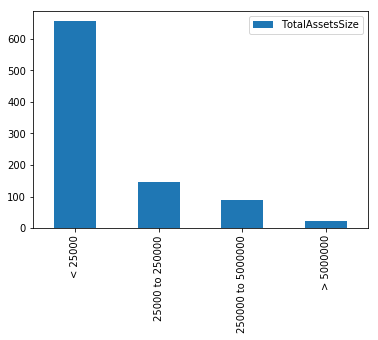

In [31]:
companies['TotalAssetsSize'].value_counts().to_frame().plot(kind='bar')

Cash
6 record(s) not included in the plot


/Users/zachangell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zachangell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


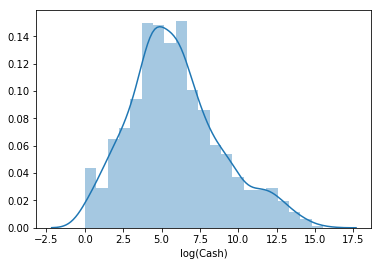

--------------------------------------------
MarketableSec
0 record(s) not included in the plot


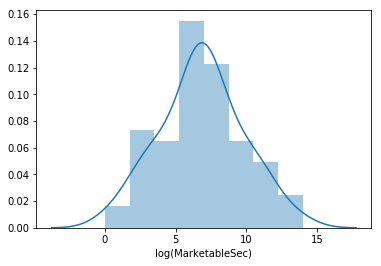

--------------------------------------------
AcctsRecTrade
1 record(s) not included in the plot


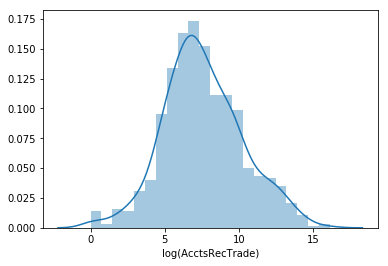

--------------------------------------------
BadDebtReserve
0 record(s) not included in the plot


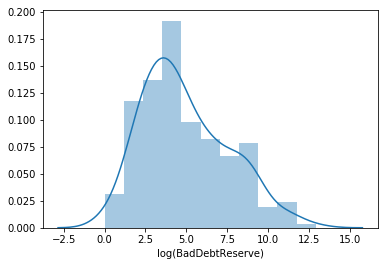

--------------------------------------------
NetTradeAcctsRec
1 record(s) not included in the plot


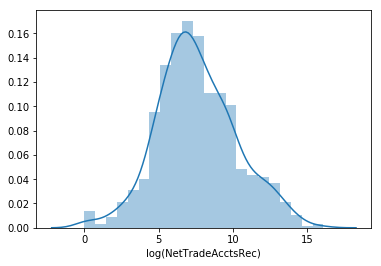

--------------------------------------------
AcctsRecOther
0 record(s) not included in the plot


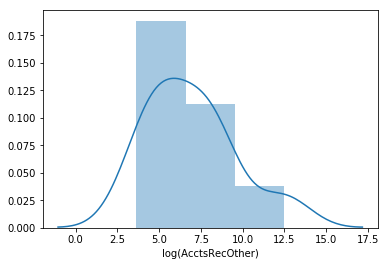

--------------------------------------------
RawMaterialsInv
0 record(s) not included in the plot


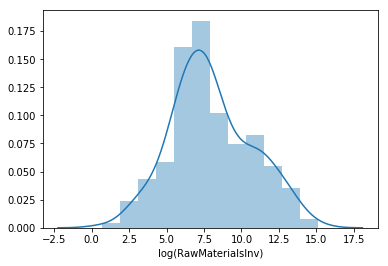

--------------------------------------------
WIPInv
0 record(s) not included in the plot


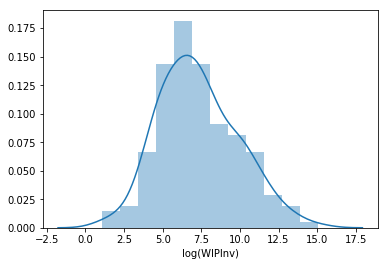

--------------------------------------------
FinGoodsInv
2 record(s) not included in the plot


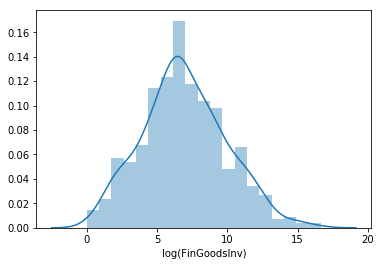

--------------------------------------------
OtherInv
12 record(s) not included in the plot


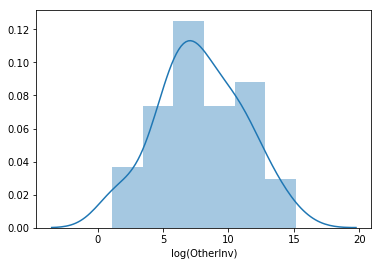

--------------------------------------------
TotalInventory
0 record(s) not included in the plot


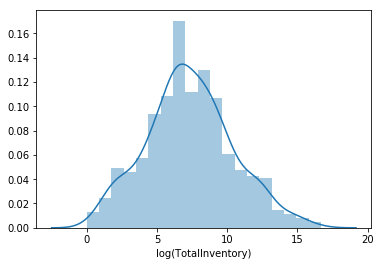

--------------------------------------------
IncTaxReceivable
0 record(s) not included in the plot


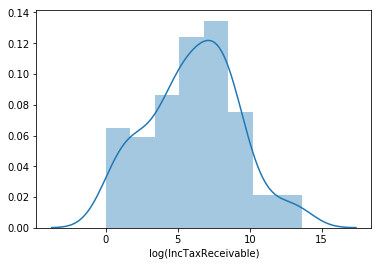

--------------------------------------------
CostsInExcBill
0 record(s) not included in the plot


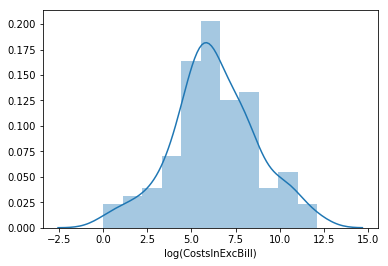

--------------------------------------------
OtherOperAssets
0 record(s) not included in the plot


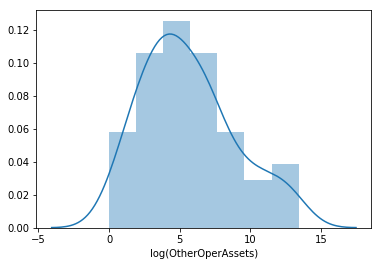

--------------------------------------------
NonOpCurAssets
1 record(s) not included in the plot


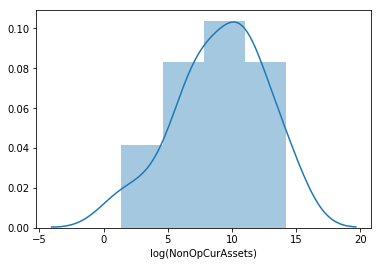

--------------------------------------------
LifoReserve
1 record(s) not included in the plot


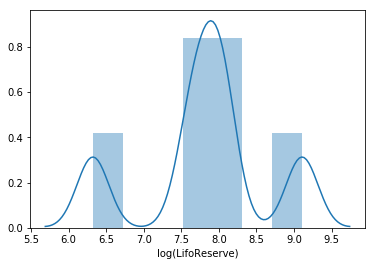

--------------------------------------------
OffBSCurAsts
0 record(s) not included in the plot


/Users/zachangell/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/zachangell/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zachangell/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


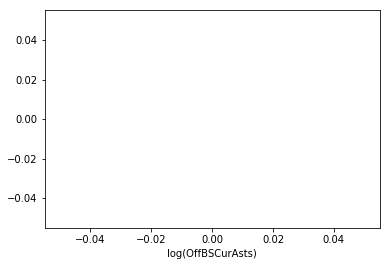

--------------------------------------------
TotalCurAssets
1 record(s) not included in the plot


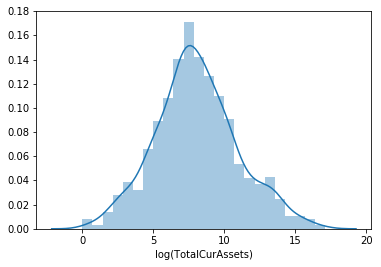

--------------------------------------------
DefIncTaxRec
0 record(s) not included in the plot


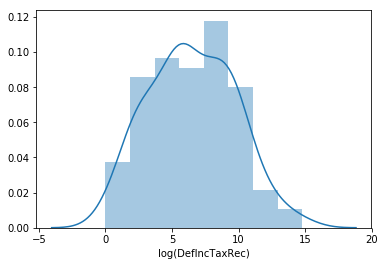

--------------------------------------------
ConstInProgress
0 record(s) not included in the plot


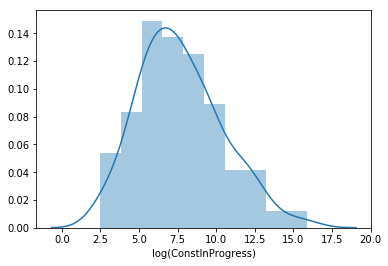

--------------------------------------------
Land
0 record(s) not included in the plot


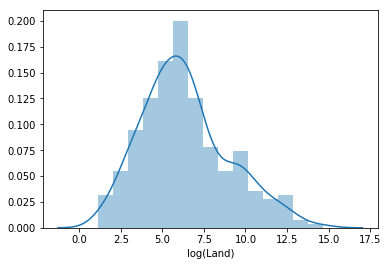

--------------------------------------------
FixedAssets
0 record(s) not included in the plot


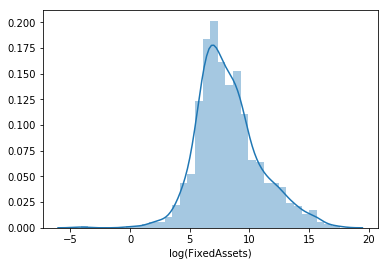

--------------------------------------------
AccumDeprec
0 record(s) not included in the plot


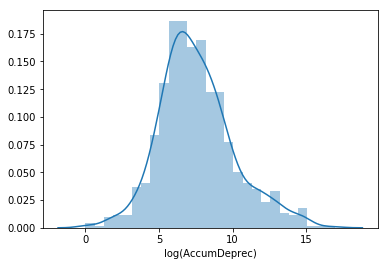

--------------------------------------------
NetFixedAssets
1 record(s) not included in the plot


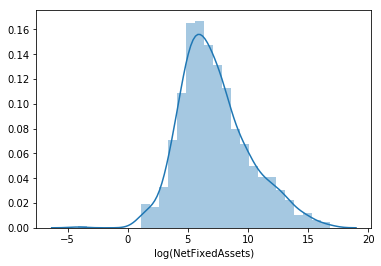

--------------------------------------------
LongTermAcctsRec
0 record(s) not included in the plot


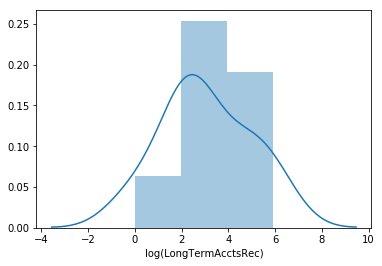

--------------------------------------------
LongTermInvest
4 record(s) not included in the plot


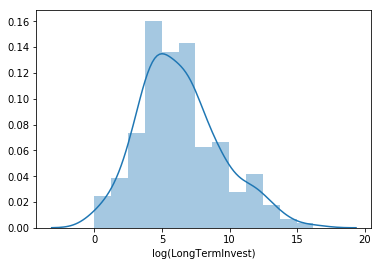

--------------------------------------------
OpNonCurAssets
0 record(s) not included in the plot


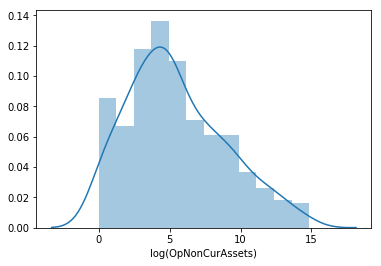

--------------------------------------------
LongTermPrepaids
1 record(s) not included in the plot


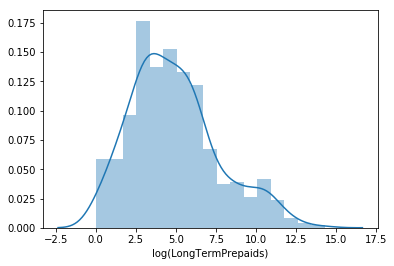

--------------------------------------------
NonOpNonCurAsts
0 record(s) not included in the plot


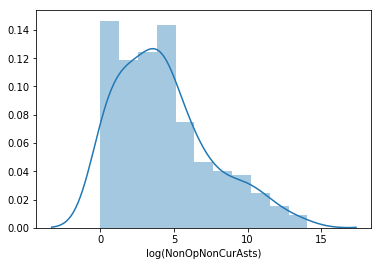

--------------------------------------------
Intangibles
0 record(s) not included in the plot


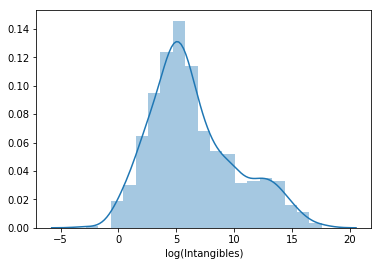

--------------------------------------------
AccumAmort
0 record(s) not included in the plot


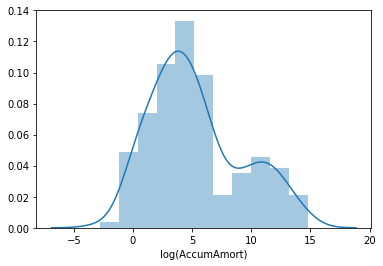

--------------------------------------------
NetIntangibles
1 record(s) not included in the plot


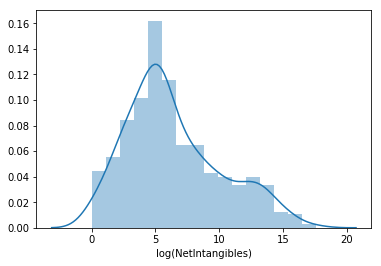

--------------------------------------------
OffBSNonCurAsts
0 record(s) not included in the plot


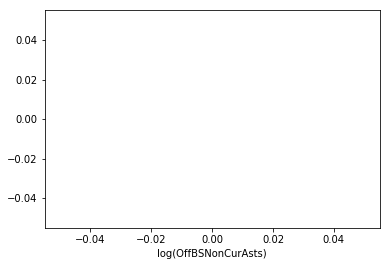

--------------------------------------------
TotalNonCurAsts
0 record(s) not included in the plot


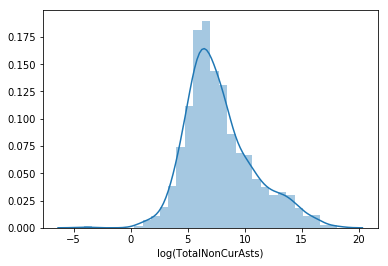

--------------------------------------------
TotalAssets
0 record(s) not included in the plot


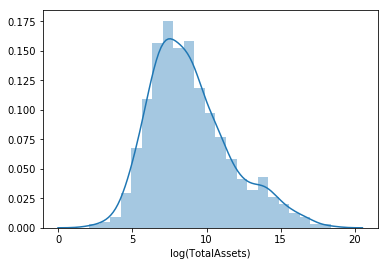

--------------------------------------------
Overdrafts
0 record(s) not included in the plot


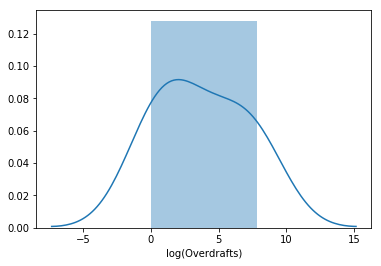

--------------------------------------------
STLoansPayable
0 record(s) not included in the plot


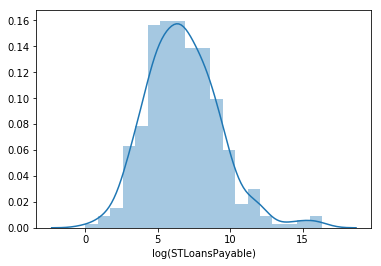

--------------------------------------------
CPLTD
1 record(s) not included in the plot


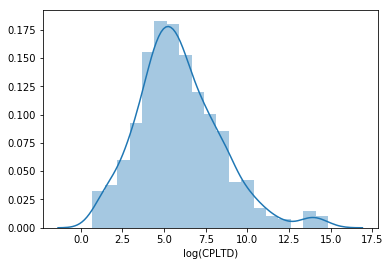

--------------------------------------------
CPSubDebt
0 record(s) not included in the plot


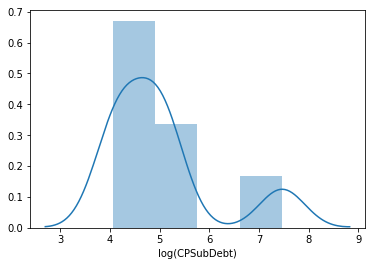

--------------------------------------------
AcctsPayTrade
0 record(s) not included in the plot


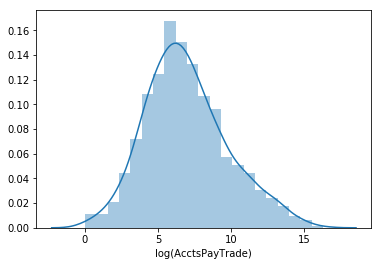

--------------------------------------------
AcctsPayOther
0 record(s) not included in the plot


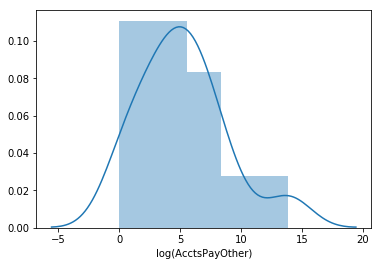

--------------------------------------------
AccruedLiabs
2 record(s) not included in the plot


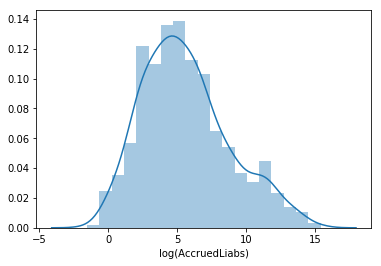

--------------------------------------------
InterestPayable
0 record(s) not included in the plot


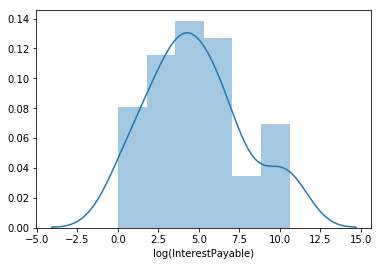

--------------------------------------------
DividendsPayable
0 record(s) not included in the plot


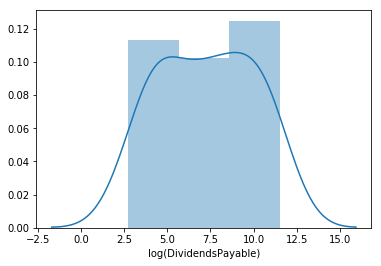

--------------------------------------------
TotalAccrdLiabs
2 record(s) not included in the plot


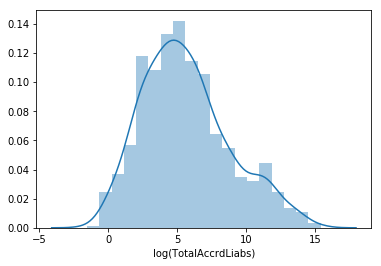

--------------------------------------------
IncTaxesPayable
2 record(s) not included in the plot


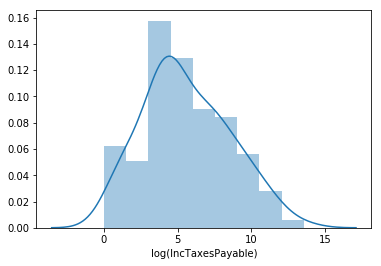

--------------------------------------------
OtherOperLiabs
2 record(s) not included in the plot


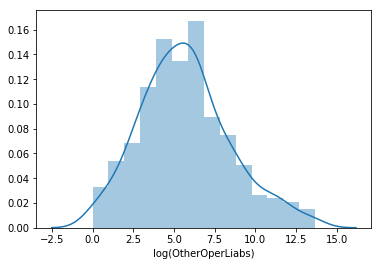

--------------------------------------------
BillInexcCosts
0 record(s) not included in the plot


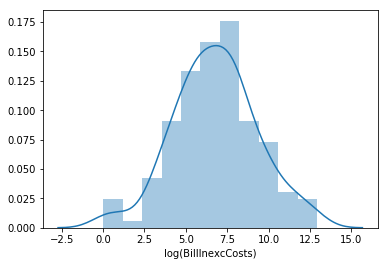

--------------------------------------------
NonOpCurLiabs
1 record(s) not included in the plot


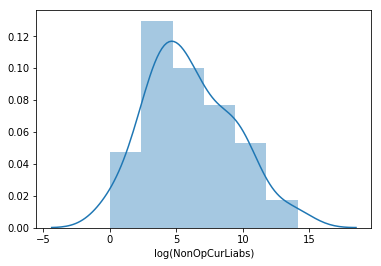

--------------------------------------------
OffBSCurLiabs
0 record(s) not included in the plot


/Users/zachangell/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/zachangell/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


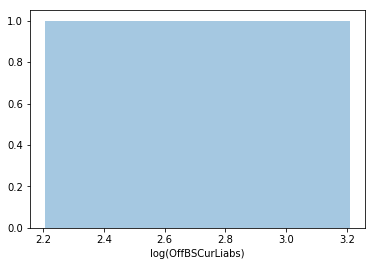

--------------------------------------------
TotalCurLiabs
0 record(s) not included in the plot


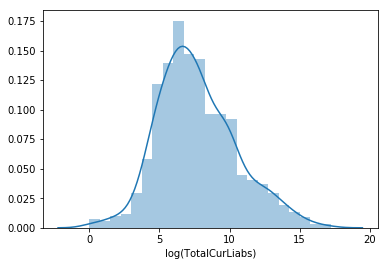

--------------------------------------------
LongTermDebt
0 record(s) not included in the plot


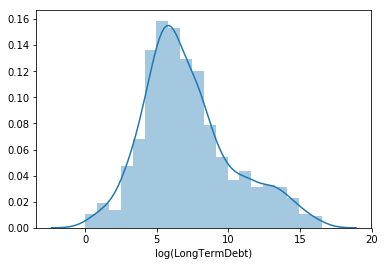

--------------------------------------------
CapLeaseOblig
0 record(s) not included in the plot


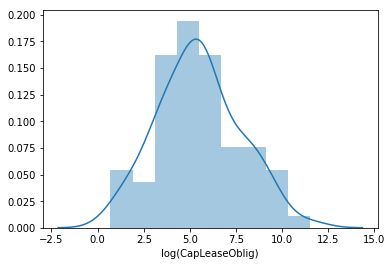

--------------------------------------------
DefIncTaxPayable
1 record(s) not included in the plot


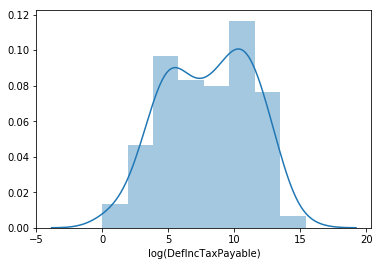

--------------------------------------------
NonOpNonCurLiabs
1 record(s) not included in the plot


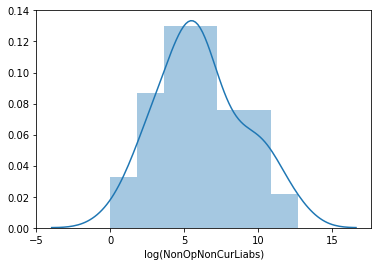

--------------------------------------------
OpNonCurLiabs
1 record(s) not included in the plot


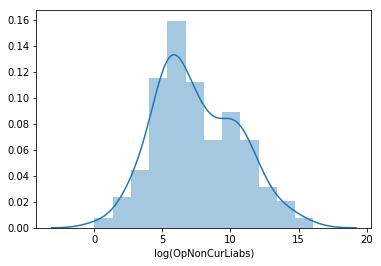

--------------------------------------------
DueToRelParty
0 record(s) not included in the plot


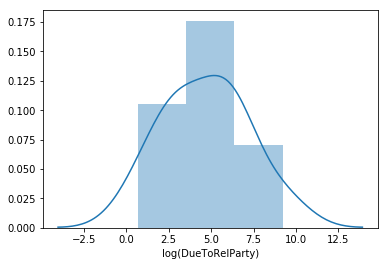

--------------------------------------------
OffBSNonCurLiabs
0 record(s) not included in the plot


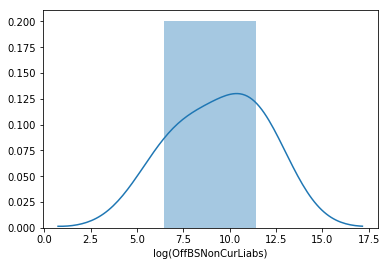

--------------------------------------------
SubDebtLiabs
0 record(s) not included in the plot


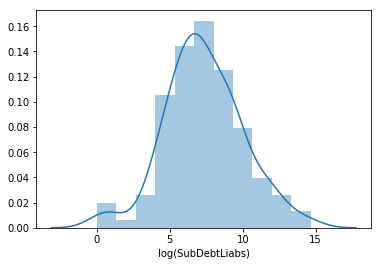

--------------------------------------------
MinorityIntLiabs
0 record(s) not included in the plot


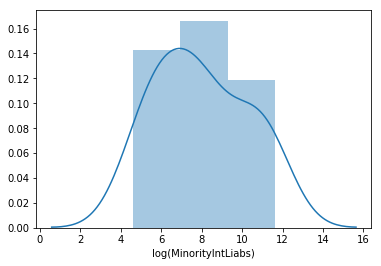

--------------------------------------------
TotalNonCurLiabs
0 record(s) not included in the plot


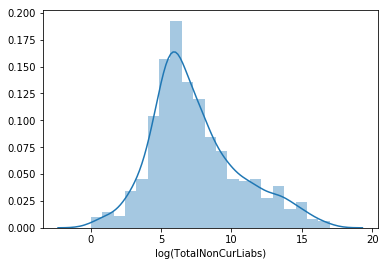

--------------------------------------------
TotalLiabs
0 record(s) not included in the plot


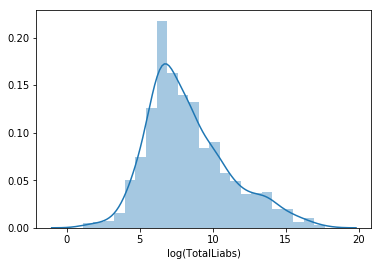

--------------------------------------------
SubDebtEquity
0 record(s) not included in the plot


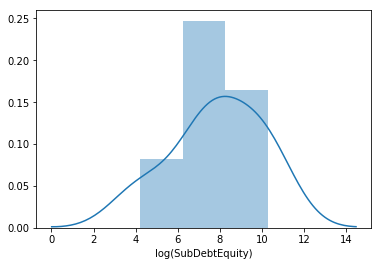

--------------------------------------------
MinIntEquity
7 record(s) not included in the plot


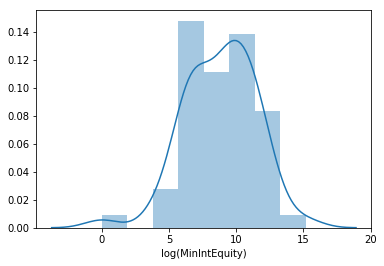

--------------------------------------------
PreferredStock
0 record(s) not included in the plot


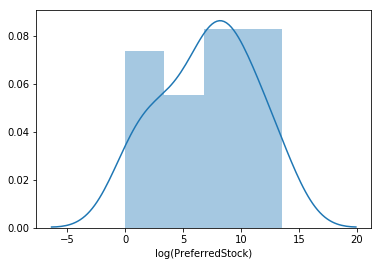

--------------------------------------------
CommonStock
2 record(s) not included in the plot


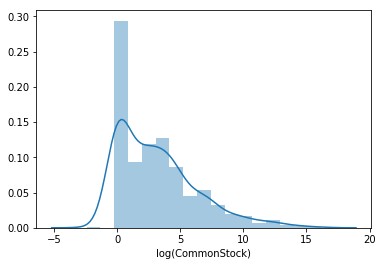

--------------------------------------------
OtherEquity
12 record(s) not included in the plot


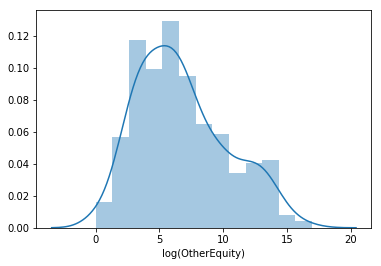

--------------------------------------------
TreasuryStock
0 record(s) not included in the plot


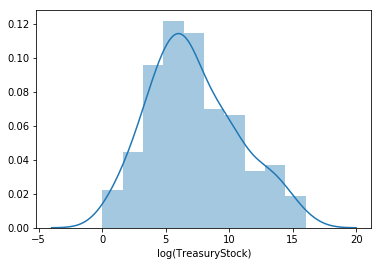

--------------------------------------------
CurrencyTranslat
3 record(s) not included in the plot


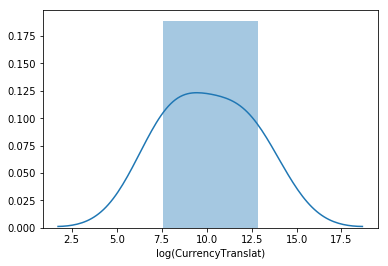

--------------------------------------------
RetainedEarnings
160 record(s) not included in the plot


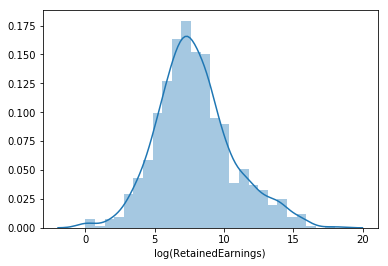

--------------------------------------------
AccumulatedOCI
131 record(s) not included in the plot


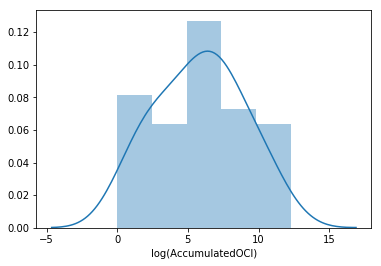

--------------------------------------------
TotalNetWorth
127 record(s) not included in the plot


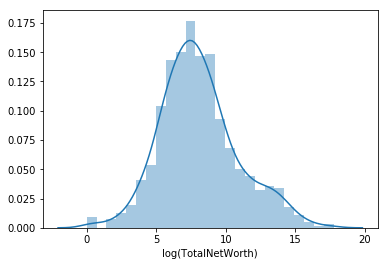

--------------------------------------------
TotLiabsNetWorth
0 record(s) not included in the plot


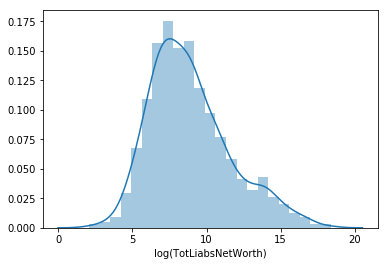

--------------------------------------------


In [32]:
for col in BS_columns:
    try:
        print(col)
        non_zero = companies[companies[col]!=0][col]
        print('%.0f record(s) not included in the plot' % np.log(non_zero).isna().sum())
        sns.distplot(np.log(non_zero).dropna())
        plt.xlabel('log(%s)' %col)
        plt.show()
        print('-'*44)
    except:
        print(col + ': can not plot because of NA value')
        print('-'*44)

In [33]:
for col in ['OffBSCurAsts', 'OffBSNonCurAsts', 'OffBSCurLiabs', 'OffBSNonCurLiabs']:
    print(col)
    print(companies[companies[col]!=0][col])
    print('-'*44)

# Based on the plots above, drop 'OffBSCurAsts' & 'OffBSNonCurAsts' column
companies = companies.drop(columns=['OffBSCurAsts', 'OffBSNonCurAsts'])

OffBSCurAsts
Series([], Name: OffBSCurAsts, dtype: float64)
--------------------------------------------
OffBSNonCurAsts
Series([], Name: OffBSNonCurAsts, dtype: float64)
--------------------------------------------
OffBSCurLiabs
506    15.0
Name: OffBSCurLiabs, dtype: float64
--------------------------------------------
OffBSNonCurLiabs
506      640.0
545    71668.0
789     4688.0
926    93492.0
Name: OffBSNonCurLiabs, dtype: float64
--------------------------------------------


#### 2.3 Income Statement Normality Check

In [34]:
print(companies.NetProfit.describe())

count    9.150000e+02
mean     3.816275e+04
std      5.793573e+05
min     -1.473113e+06
25%      8.500000e+00
50%      1.950000e+02
75%      1.586000e+03
max      1.682498e+07
Name: NetProfit, dtype: float64


In [35]:
def net_profit_log(row):
    if row['NetProfit'] == 0:
        return np.NaN
    elif row['NetProfit'] > 0:
        return np.log(row['NetProfit'])
    else:
        return -(np.log(row['NetProfit']))
companies['LogNetProfit'] = companies.apply(net_profit_log, axis=1)

/Users/zachangell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


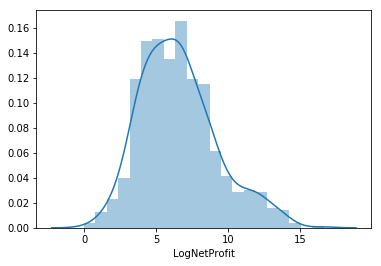

In [36]:
sns.distplot(companies['LogNetProfit'].dropna())

GrossSales
1 record(s) not included in the plot


/Users/zachangell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zachangell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


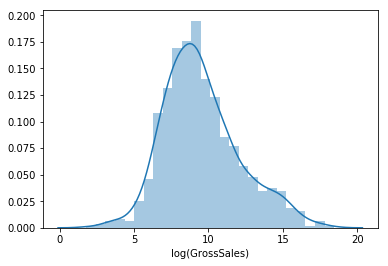

--------------------------------------------
SalesReturns
2 record(s) not included in the plot


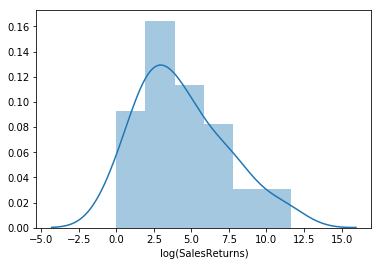

--------------------------------------------
NetSales
1 record(s) not included in the plot


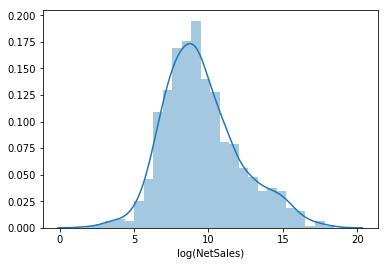

--------------------------------------------
CostOfGoodsSold
0 record(s) not included in the plot


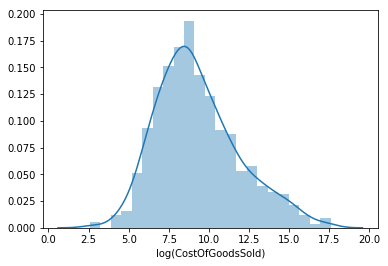

--------------------------------------------
COGSDepreciation
1 record(s) not included in the plot


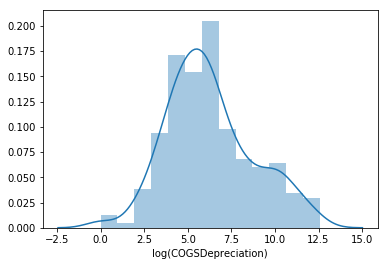

--------------------------------------------
TotalCOGS
0 record(s) not included in the plot


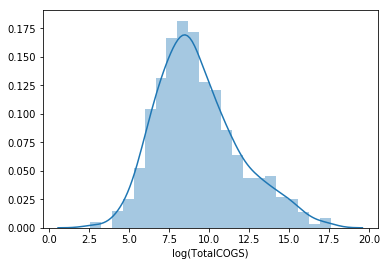

--------------------------------------------
GrossProfit
10 record(s) not included in the plot


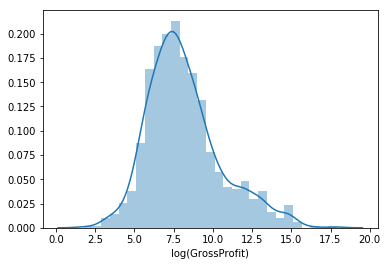

--------------------------------------------
OperExpenses
5 record(s) not included in the plot


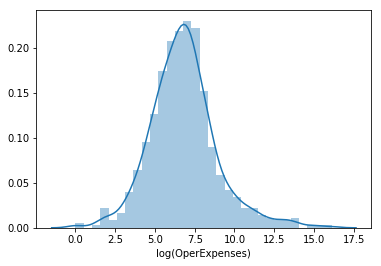

--------------------------------------------
SellingAndGenExp
1 record(s) not included in the plot


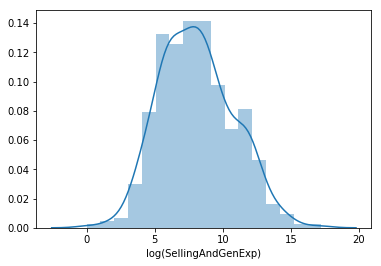

--------------------------------------------
OfficersComp
0 record(s) not included in the plot


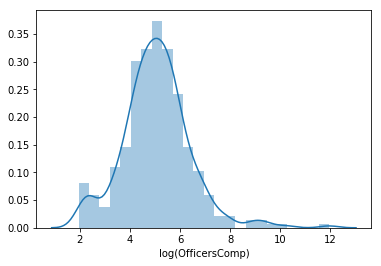

--------------------------------------------
LeaseRentExp
1 record(s) not included in the plot


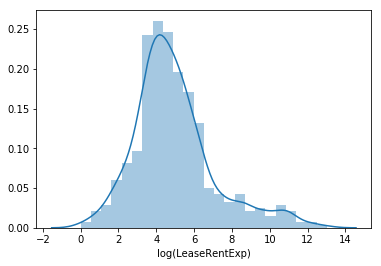

--------------------------------------------
DeprecExpense
1 record(s) not included in the plot


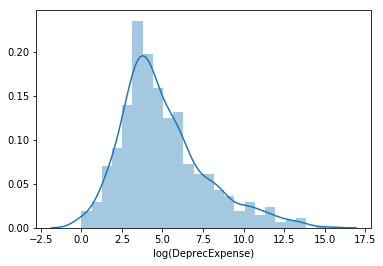

--------------------------------------------
AmortExpense
1 record(s) not included in the plot


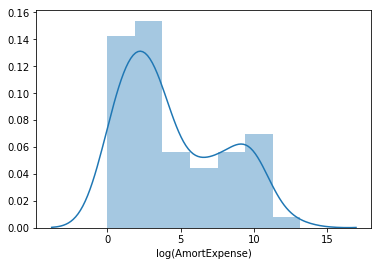

--------------------------------------------
ESOPDividends
0 record(s) not included in the plot


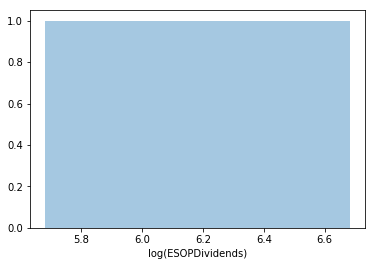

--------------------------------------------
TotalOpExpenses
0 record(s) not included in the plot


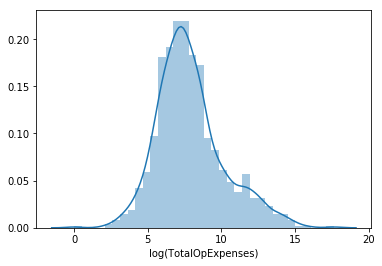

--------------------------------------------
OtherOperIncome
0 record(s) not included in the plot


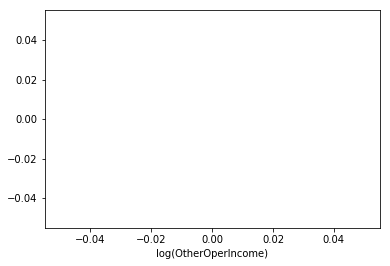

--------------------------------------------
NetOpProfit
165 record(s) not included in the plot


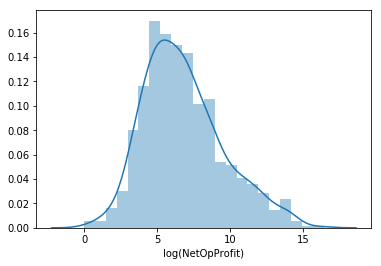

--------------------------------------------
InterestIncome
0 record(s) not included in the plot


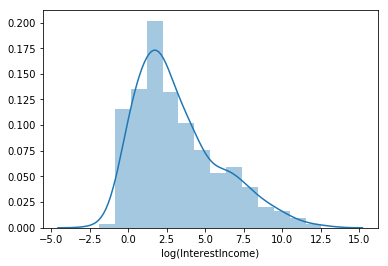

--------------------------------------------
InterestExpense
0 record(s) not included in the plot


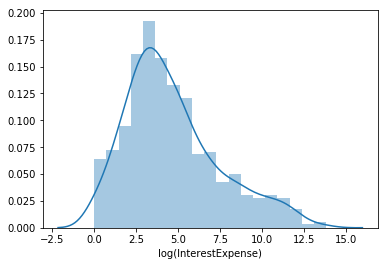

--------------------------------------------
NonCashIncome
4 record(s) not included in the plot


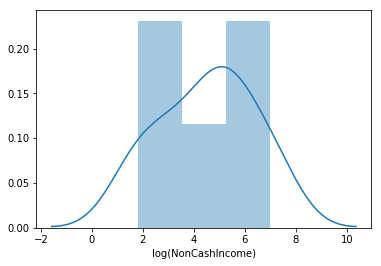

--------------------------------------------
NonCashExpense
1 record(s) not included in the plot


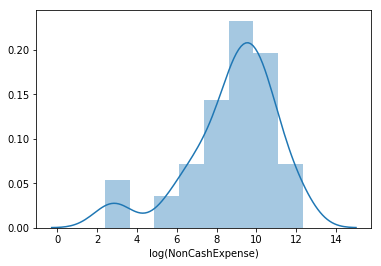

--------------------------------------------
OtherIncome
33 record(s) not included in the plot


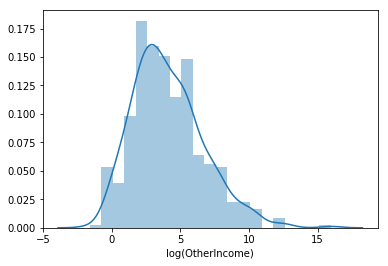

--------------------------------------------
IncomeFromSubs
11 record(s) not included in the plot


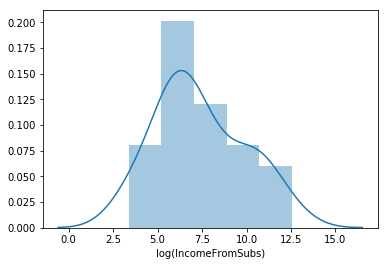

--------------------------------------------
GainLossAstSale
80 record(s) not included in the plot


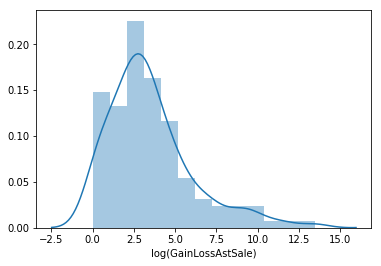

--------------------------------------------
OtherExpense
14 record(s) not included in the plot


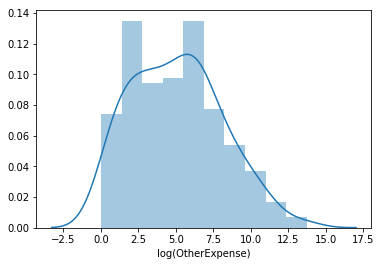

--------------------------------------------
TotalOtherIncExp
653 record(s) not included in the plot


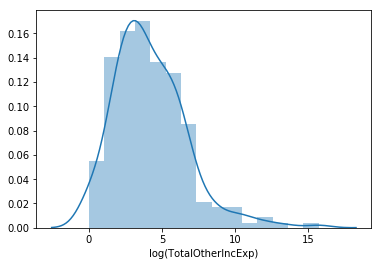

--------------------------------------------
ProfitBeforeTax
203 record(s) not included in the plot


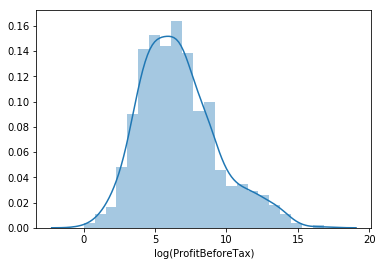

--------------------------------------------
IncomeTaxExp
56 record(s) not included in the plot


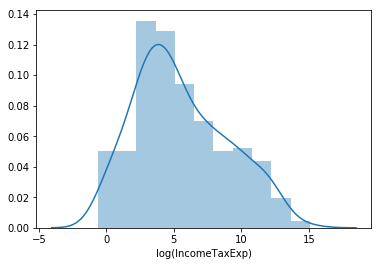

--------------------------------------------
IncomeTaxCredit
0 record(s) not included in the plot


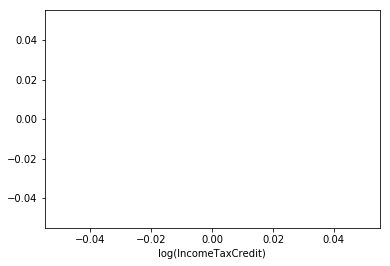

--------------------------------------------
NetIncomeTaxExp
56 record(s) not included in the plot


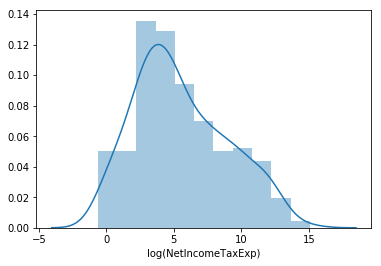

--------------------------------------------
MinorityIntExp
18 record(s) not included in the plot


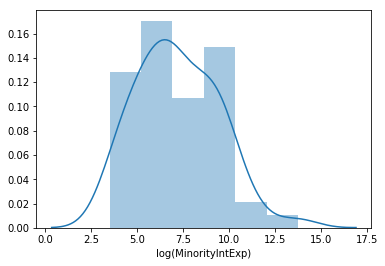

--------------------------------------------
ProfitB4ExtItems
209 record(s) not included in the plot


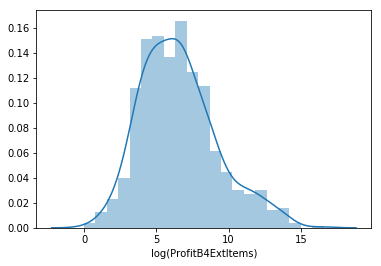

--------------------------------------------
AfterTaxIncome
13 record(s) not included in the plot


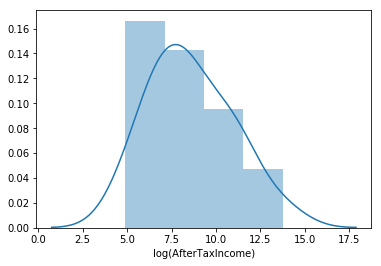

--------------------------------------------
AftTaxNonCashExp
0 record(s) not included in the plot


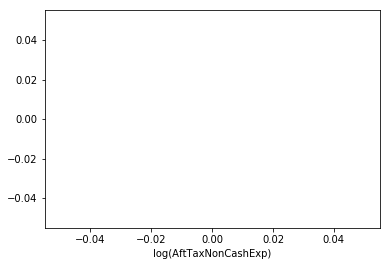

--------------------------------------------
AfterTaxExpense
2 record(s) not included in the plot


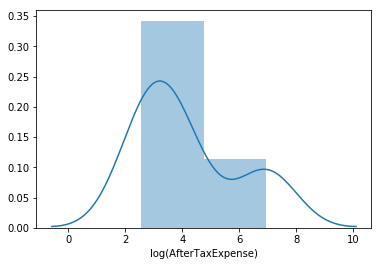

--------------------------------------------
NetProfit
212 record(s) not included in the plot


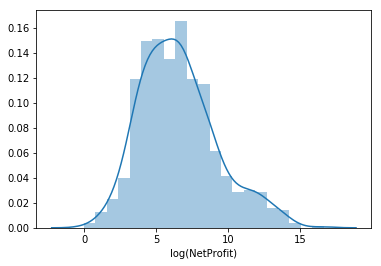

--------------------------------------------
OtherCompIncome
64 record(s) not included in the plot


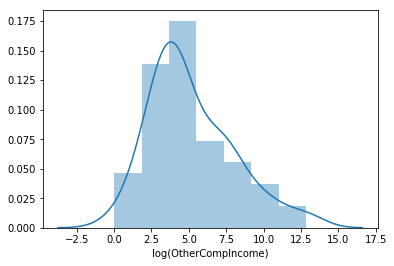

--------------------------------------------
CompIncome
215 record(s) not included in the plot


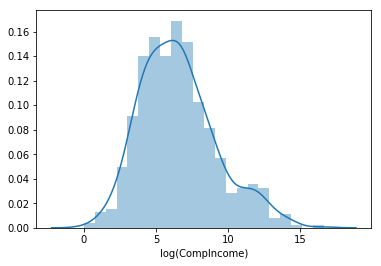

--------------------------------------------
DividendsStock
0 record(s) not included in the plot


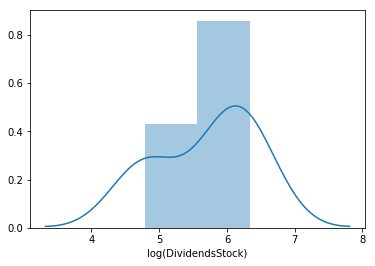

--------------------------------------------
DividendsCommon
4 record(s) not included in the plot


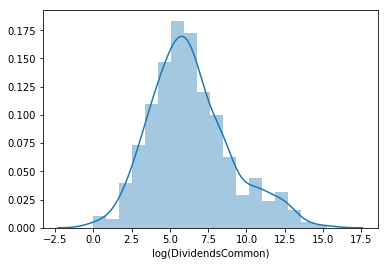

--------------------------------------------
DividendsPref
0 record(s) not included in the plot


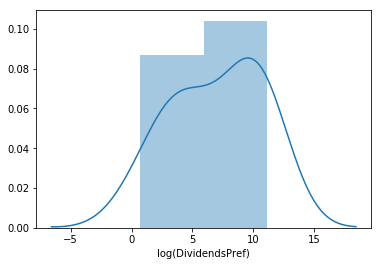

--------------------------------------------
AdjToRE
157 record(s) not included in the plot


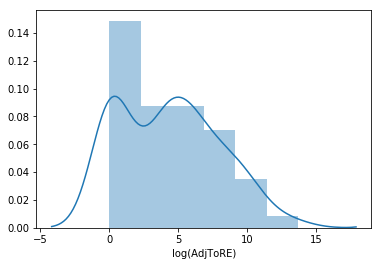

--------------------------------------------


In [37]:
for col in IS_columns:
    try:
        print(col)
        non_zero = companies[companies[col]!=0][col]
        print('%.0f record(s) not included in the plot' % np.log(non_zero).isna().sum())
        sns.distplot(np.log(non_zero).dropna()) 
        plt.xlabel('log(%s)' %col)
        plt.show()
        print('-'*44)
    except:
        print(col + ': can not plot because of NA value')
        print('-'*44)

In [38]:
for col in ['ESOPDividends', 'OtherOperIncome', 'IncomeTaxCredit', 'AftTaxNonCashExp']:
    print(col)
    print(companies[companies[col]!=0][col])
    print('-'*44)
    
# drop the three columns without meaningful value
companies = companies.drop(columns=['OtherOperIncome', 'IncomeTaxCredit', 'AftTaxNonCashExp'])

ESOPDividends
801    484.0
Name: ESOPDividends, dtype: float64
--------------------------------------------
OtherOperIncome
Series([], Name: OtherOperIncome, dtype: int64)
--------------------------------------------
IncomeTaxCredit
Series([], Name: IncomeTaxCredit, dtype: float64)
--------------------------------------------
AftTaxNonCashExp
Series([], Name: AftTaxNonCashExp, dtype: int64)
--------------------------------------------


#### 2.4 Ratios Check

In [39]:
companies[['QuickRatio', 'CurrentRatio']].head()

,QuickRatio,CurrentRatio
0,0.777749,1.777228
1,0.982673,1.689356
2,0.748851,1.538285
3,0.707674,1.533997
4,0.067571,0.439980


In [40]:
# deal with 999/-999
# deal with negativa ratio
for col in ['QuickRatio', 'CurrentRatio']:
    companies[col] = companies[col].replace(999.0, np.nan).replace(-999.0, np.nan)
    companies = companies[~(companies[col]<0)]

In [41]:
companies[['QuickRatio', 'CurrentRatio']].head()

,QuickRatio,CurrentRatio
0,0.777749,1.777228
1,0.982673,1.689356
2,0.748851,1.538285
3,0.707674,1.533997
4,0.067571,0.439980


QuickRatio
--------------------------------------------
count    897.000000
mean       2.674387
std       11.472159
min        0.000000
25%        0.465527
50%        0.917316
75%        1.677854
max      160.400000
Name: QuickRatio, dtype: float64


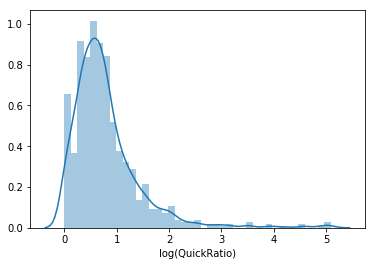

CurrentRatio
--------------------------------------------
count     897.000000
mean        6.514339
std        87.208970
min         0.000000
25%         1.006424
50%         1.533997
75%         2.552158
max      2578.500000
Name: CurrentRatio, dtype: float64


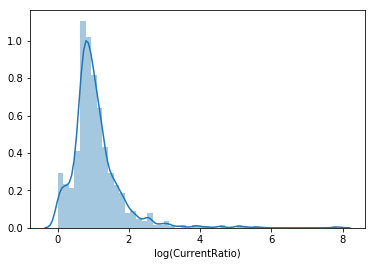

In [42]:
for col in ['QuickRatio', 'CurrentRatio']:
    print(col)
    print('-'*44)
    print(companies[col].describe())
    sns.distplot(np.log(companies[col].dropna()-min(companies[col].dropna())+1).dropna())
    plt.xlabel('log(%s)' %col)
    plt.show()

#### 2.5 Growth Rate Check

In [43]:
# replace 999/-999 in those columns
for col in Growth_columns:
    companies[col] = companies[col].replace(999.0, np.nan).replace(-999.0, np.nan)

companies[Growth_columns].head()

,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,AdjustedEBITDAGrowth,GrossProfitGrowth,SustainableGrow
0,-2.447463,-23.176452,76.619371,-2.993928,NaN,NaN,4640.000000,6.424062,76.619371
1,6.161616,-6.326384,35.653650,9.858156,3.619048,180.000000,182.857143,17.727273,35.653650
2,-5.329867,-13.591703,6.827309,11.683202,-0.634921,-71.283784,-40.608229,43.606093,6.827309
3,2.767468,-3.600289,12.773926,11.291525,0.122379,-22.546270,7.500323,6.230269,7.064722
4,-27.113191,-21.876208,NaN,14.285409,NaN,NaN,NaN,1954.863222,-4.388784


TotalAssetsGrowth
--------------------------------------------
count     848.000000
mean       16.295940
std        86.929527
min       -92.869437
25%        -6.352581
50%         3.081977
75%        16.752040
max      1775.000000
Name: TotalAssetsGrowth, dtype: float64
66 record(s) not included in the plot


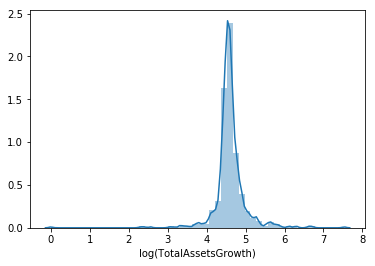

TotalLiabsGrowth
--------------------------------------------
count      845.000000
mean        61.091825
std        656.539435
min        -98.688047
25%        -14.864061
50%          0.000000
75%         20.460793
max      13354.166670
Name: TotalLiabsGrowth, dtype: float64
69 record(s) not included in the plot


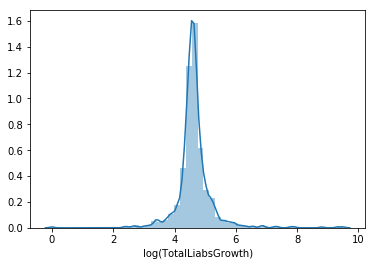

NetWorthGrowth
--------------------------------------------
count     720.000000
mean       44.569399
std       217.064275
min       -98.814095
25%        -3.750739
50%         7.273981
75%        25.165625
max      2836.714976
Name: NetWorthGrowth, dtype: float64
194 record(s) not included in the plot


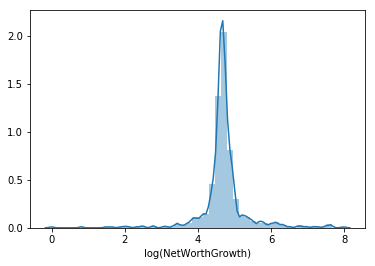

NetSalesGrowth
--------------------------------------------
count     842.000000
mean       12.946268
std        68.443920
min       -99.191291
25%        -5.794439
50%         4.765658
75%        15.765910
max      1134.959350
Name: NetSalesGrowth, dtype: float64
72 record(s) not included in the plot


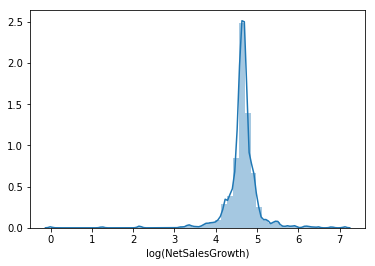

OpProfitGrowth
--------------------------------------------
count    608.000000
mean       0.969401
std        3.997091
min       -0.963033
25%       -0.236596
50%        0.141804
75%        0.735881
max       56.642857
Name: OpProfitGrowth, dtype: float64
306 record(s) not included in the plot


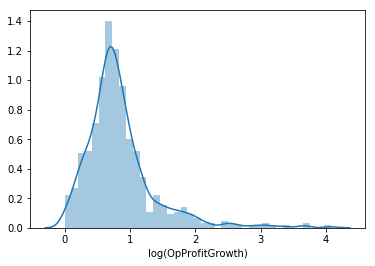

NetProfitGrowth
--------------------------------------------
count      558.000000
mean       134.338178
std        759.904826
min        -98.730734
25%        -31.723614
50%          9.531914
75%         85.776676
max      13366.666670
Name: NetProfitGrowth, dtype: float64
356 record(s) not included in the plot


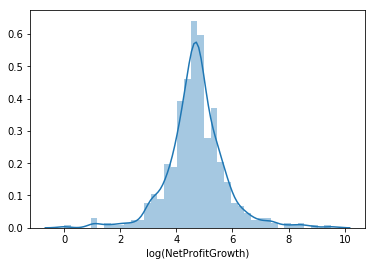

AdjustedEBITDAGrowth
--------------------------------------------
count     701.000000
mean       57.865684
std       293.106140
min       -99.099099
25%       -23.796791
50%         7.633872
75%        50.480769
max      4640.000000
Name: AdjustedEBITDAGrowth, dtype: float64
213 record(s) not included in the plot


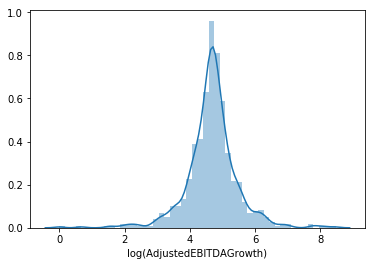

GrossProfitGrowth
--------------------------------------------
count     832.000000
mean       21.426738
std       127.922566
min       -96.373780
25%       -10.437696
50%         4.558753
75%        23.581308
max      1954.863222
Name: GrossProfitGrowth, dtype: float64
82 record(s) not included in the plot


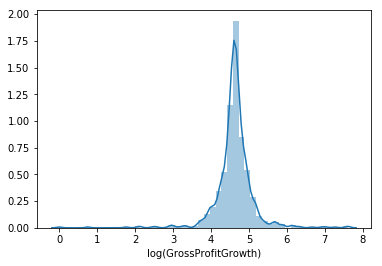

SustainableGrow
--------------------------------------------
count      908.000000
mean       -19.292530
std       1122.547016
min     -32097.135420
25%         -9.891304
50%          5.269681
75%         22.134344
max       5993.589744
Name: SustainableGrow, dtype: float64
6 record(s) not included in the plot


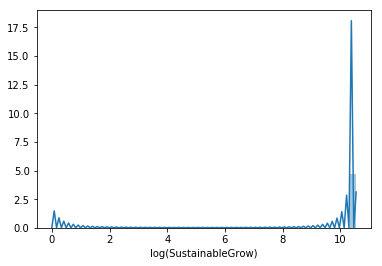

In [44]:
for col in Growth_columns:
    print(col)
    print('-'*44)
    print(companies[col].describe())
    print('%.0f record(s) not included in the plot' % companies[col].isna().sum())
    sns.distplot(np.log(companies[col].dropna() - min(companies[col].dropna()) + 1))
    plt.xlabel('log(%s)' %col)
    plt.show()

as growth rates are not as important as items in BS&IS, no record was filtered out based on growth rate.
***
### Cleaned Data

In [45]:
# drop non-original columns 
companies.drop(columns=['BS_null',
                       'IS_null',
                       'BS_1',
                       'BS_2',
                       'IS_1',
                       'Ratio_Check',
                       'Bad_Prep',
                       'validation_fails',
                       'BS_completeness',
                       'IS_completeness',
                       'TotalAssetsSize',
                       'LogNetProfit'], inplace=True)
companies.to_csv('cleaned_data_v2.csv')

In [46]:
print ('Companies: %.0f, Fields: %.0f' % (companies.shape))
companies.head()

Companies: 914, Fields: 130


,masked EntityID,CPR $net_inc_YTD,CPR_Group,IndustryCode,AuditMethod,StatementType,Cash,MarketableSec,AcctsRecTrade,BadDebtReserve,NetTradeAcctsRec,AcctsRecOther,RawMaterialsInv,WIPInv,FinGoodsInv,OtherInv,TotalInventory,IncTaxReceivable,CostsInExcBill,OtherOperAssets,NonOpCurAssets,LifoReserve,TotalCurAssets,DefIncTaxRec,ConstInProgress,Land,FixedAssets,AccumDeprec,NetFixedAssets,LongTermAcctsRec,LongTermInvest,OpNonCurAssets,LongTermPrepaids,NonOpNonCurAsts,Intangibles,AccumAmort,NetIntangibles,TotalNonCurAsts,TotalAssets,Overdrafts,STLoansPayable,CPLTD,CPSubDebt,AcctsPayTrade,AcctsPayOther,AccruedLiabs,InterestPayable,DividendsPayable,TotalAccrdLiabs,IncTaxesPayable,OtherOperLiabs,BillInexcCosts,NonOpCurLiabs,OffBSCurLiabs,TotalCurLiabs,LongTermDebt,CapLeaseOblig,DefIncTaxPayable,NonOpNonCurLiabs,OpNonCurLiabs,DueToRelParty,OffBSNonCurLiabs,SubDebtLiabs,MinorityIntLiabs,TotalNonCurLiabs,TotalLiabs,SubDebtEquity,MinIntEquity,PreferredStock,CommonStock,OtherEquity,TreasuryStock,CurrencyTranslat,RetainedEarnings,AccumulatedOCI,TotalNetWorth,TotLiabsNetWorth,GrossSales,SalesReturns,NetSales,CostOfGoodsSold,COGSDepreciation,TotalCOGS,GrossProfit,OperExpenses,SellingAndGenExp,OfficersComp,LeaseRentExp,DeprecExpense,AmortExpense,ESOPDividends,TotalOpExpenses,NetOpProfit,InterestIncome,InterestExpense,NonCashIncome,NonCashExpense,OtherIncome,IncomeFromSubs,GainLossAstSale,OtherExpense,TotalOtherIncExp,ProfitBeforeTax,IncomeTaxExp,NetIncomeTaxExp,MinorityIntExp,ProfitB4ExtItems,AfterTaxIncome,AfterTaxExpense,NetProfit,OtherCompIncome,CompIncome,DividendsStock,DividendsCommon,DividendsPref,AdjToRE,ConversionRate,QuickRatio,CurrentRatio,Year,TotalAssetsGrowth,TotalLiabsGrowth,NetWorthGrowth,NetSalesGrowth,OpProfitGrowth,NetProfitGrowth,AdjustedEBITDAGrowth,GrossProfitGrowth,SustainableGrow,IndustryType
0,131294,NaN,NaN,332618,Compiled,Annual,365.0,0.0,2620.0,0.0,2620.0,0,0.0,0.0,3836.0,0.0,3836.0,0.0,0.0,0.0,0.0,0.0,6821.0,0.0,0.0,47.0,7488.0,6938.0,550.0,0,165.0,50.0,27.0,0.0,0.0,0.0,0.0,792.0,7613.0,0.0,2175.0,315.0,0,1241.0,0.0,49.0,0.0,0.0,49.0,47.0,11.0,0.0,0.0,0.0,3838.0,912.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,912.0,4750.0,0,0.0,0,936.0,0.0,0.0,0.0,1927.0,0.0,2863.0,7613.0,13900.0,0.0,13900.0,10922.0,112.0,11034.0,2866.0,1263.0,1241.0,0.0,0.0,7.0,0.0,0.0,2511.0,355.0,0.0,553.0,0.0,0.0,0.0,0.0,1482.0,0.0,929.0,1284.0,42.0,42.0,0.0,1242.0,0.0,0,1242.0,0.0,1242.0,0,0.0,0,0.0,1.0,0.777749,1.777228,2007,-2.447463,-23.176452,76.619371,-2.993928,NaN,NaN,4640.000000,6.424062,76.619371,Manufacturing
1,24997,1338.601967,BUSINESS BANKING,332810,Compiled,Annual,6.0,0.0,798.0,10.0,788.0,0,0.0,0.0,0.0,571.0,571.0,0.0,0.0,0.0,0.0,0.0,1365.0,249.0,0.0,0.0,3919.0,3541.0,378.0,0,1.0,84.0,25.0,0.0,0.0,0.0,0.0,737.0,2102.0,0.0,200.0,115.0,0,428.0,0.0,65.0,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,808.0,256.0,0.0,0.0,0,239.0,0,0.0,0.0,0.0,495.0,1303.0,0,0.0,0,32.0,0.0,365.0,0.0,1132.0,0.0,799.0,2102.0,6196.0,0.0,6196.0,4537.0,105.0,4642.0,1554.0,1061.0,0.0,202.0,0.0,0.0,0.0,0.0,1263.0,291.0,0.0,56.0,0.0,0.0,0.0,0.0,-2.0,0.0,-58.0,233.0,23.0,23.0,0.0,210.0,0.0,0,210.0,0.0,210.0,0,0.0,0,0.0,1.0,0.982673,1.689356,2008,6.161616,-6.326384,35.653650,9.858156,3.619048,180.000000,182.857143,17.727273,35.653650,Manufacturing
2,31667,0.000000,BUSINESS BANKING,311812,Reviewed,Annual,209.0,0.0,769.0,0.0,769.0,0,0.0,0.0,1031.0,0.0,1031.0,0.0,0.0,0.0,0.0,0.0,2009.0,28.0,0.0,0.0,2723.0,1876.0,847.0,0,0.0,2.0,26.0,1.0,0.0,0.0,0.0,904.0,2913.0,0.0,0.0,96.0,0,858.0,0.0,28.0,0.0,0.0,28.0,0.0,324.0,0.0,0.0,0.0,1306.0,117.0,0.0,160.0,0,0.0,0,0.0,0.0,0.0,277.0,1583.0,0,0.0,0,1.0,0.0,155.0,0.0,1484.0,0.0,1330.0,2913.0,13058.0,0.0,13058.0,8813.0,191.0,9004.0,4054.0,2078.0,0.0,1833.0,2.0,3.0,0.0,0.0,3916.0,138.0,3.0,33.0,0.0,0.0,0.0,0.0,1.0,0.0,-29.0,109.0,24.0,24.0,0.0,85.0,0.0,0,85.0,0.0,85.0,0,0.0,0,0.0,1.0,0.748851,1.538285,2009,-5.329867,-13.591703,6.827309,11.683202,-0.634921,-71.283784,-40.608229,43.606093,6.827309,Manufacturing
3,146177,NaN,NaN,332999,Unqualif'd,Annual,16127.0,0.0